In [6]:
from dataclasses import dataclass
from types import SimpleNamespace
from typing import Optional, Tuple, Dict
import os, time, math
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math
import itertools
import ellipse_mean_stable as em

In [7]:
''' Here we test for different values of:
    beta
    tau
    iterations (1,2,3,4,5)
    R_max

    tau schedule (constant, increasing , decreasing) and tilde mu_0 - this will be done in a separate script
'''

' Here we test for different values of:\n    beta\n    tau\n    iterations (1,2,3,4,5)\n    R_max\n\n    tau schedule (constant, increasing , decreasing) and tilde mu_0 - this will be done in a separate script\n'

In [8]:
# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed: int, device: str):
    torch.manual_seed(seed)
    if device.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)


def make_spd_cov(d: int, device: str, dtype: torch.dtype, seed: int = 0):
    """Random SPD covariance with moderate conditioning."""
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    B = torch.randn(d,d, generator=g, device=device, dtype=dtype)
    Sigma = (B @ B.T) / d + 0.2 * torch.eye(d, device=device, dtype=dtype)
    return Sigma


def maha_error(mu_hat: torch.Tensor, mu_true: torch.Tensor, Sigma_true: torch.Tensor) -> float:
    """Mahalanobis norm ||mu_hat - mu||_{Sigma^{-1}}."""
    delta = (mu_hat - mu_true).to(Sigma_true.device, Sigma_true.dtype)
    Sinv = torch.linalg.inv(Sigma_true)
    val = delta @ Sinv @ delta
    return float(torch.sqrt(torch.clamp(val, min=0.0)).item())


In [9]:
# Data generators
# -----------------------------
#####  no grad speeds it up
@torch.no_grad()
def sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    return mu_true.unsqueeze(0) + Z @ L.T

##### I didn't end up using this
@torch.no_grad()
def sample_skewed(n, d, mu_true, Sigma_true, skew_dir, skew_scale,
                  device, dtype, seed):
    """
    skew_dir   : (d,) direction of skew (unit vector recommended)
    skew_scale : scalar controlling skew strength
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)

    # Latent skew variable
    U = torch.randn(n, 1, generator=g, device=device, dtype=dtype)
    skew = skew_scale * torch.relu(U) * skew_dir.view(1, -1)

    X = Z @ L.T + skew
    return mu_true.unsqueeze(0) + X



@torch.no_grad()
def sample_contaminated_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed,
                                eta=0.1, shift_scale=8.0, inflate=3.0):
    """
    Huber contamination: (1-eta) N(mu, Sigma) + eta N(mu + shift, inflate*Sigma).
    shift direction is random but fixed per seed.
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    # clean
    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype)
    X_clean = mu_true.unsqueeze(0) + Z @ L.T

    # contam mask
    mask = (torch.rand(n, generator=g, device=device) < eta)
    m = int(mask.sum().item())
    if m == 0:
        return X_clean

    # contamination distribution
    # random shift direction
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    v = v / torch.linalg.norm(v).clamp_min(1e-12)
    shift = shift_scale * v  # magnitude

    Sigma_cont = inflate * Sigma_true
    Lc = torch.linalg.cholesky(Sigma_cont)
    Zc = torch.randn(m, d, generator=g, device=device, dtype=dtype)
    X_cont = (mu_true + shift).unsqueeze(0) + Zc @ Lc.T

    X = X_clean.clone()
    X[mask] = X_cont
    return X


@torch.no_grad()
def sample_banana(n, d, mu_true, Sigma_true,
                  device, dtype, seed, b=0.2):
    """
    Banana-shaped distribution:
      Start with Y ~ N(0, Sigma_true), then warp:
        X1 = Y1
        X2 = Y2 + b*(Y1^2 - E[Y1^2])
      and keep remaining coords as-is.
    This is strongly non-elliptical (curved level sets).
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Y = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T

    # Warp in first two coordinates
    y1 = Y[:, 0]
    y2 = Y[:, 1]
    # Center the quadratic term so mean stays controlled
    y1_var = torch.var(y1, unbiased=False)
    Y[:, 1] = y2 + b * (y1**2 - y1_var)

    return mu_true.view(1, d) + Y


@torch.no_grad()
def sample_multivariate_t(n, d, mu_true, Sigma_true, device, dtype, seed, df=3.0):
    """
    Multivariate t via scale-mixture:
      X = mu + Z / sqrt(U/df),  Z ~ N(0,Sigma), U ~ ChiSquare(df)
    """
    g = torch.Generator(device=device)
    g.manual_seed(seed)

    L = torch.linalg.cholesky(Sigma_true)
    Z = torch.randn(n, d, generator=g, device=device, dtype=dtype) @ L.T  # N(0,Sigma)

    # Chi-square(df) can be sampled via Gamma(k=df/2, theta=2)
    # U ~ Gamma(df/2, 2)
    U = torch.distributions.Gamma(concentration=df/2.0, rate=0.5).sample((n,)).to(device=device, dtype=dtype)
    scale = torch.sqrt(U / df).clamp_min(1e-12)  # (n,)

    X = mu_true.unsqueeze(0) + Z / scale.unsqueeze(1)
    return X



In [10]:
def random_skew_dir(d, device, dtype, seed):
    g = torch.Generator(device=device)
    g.manual_seed(seed)
    v = torch.randn(d, generator=g, device=device, dtype=dtype)
    return v / torch.norm(v)

def _setting_seed(seed0, rep, n, d, rho, *, dist, R_max=None, beta=None, tau=None, iters=None):
    # Stable integer tags for floats
    rho_tag  = int(round(1e6 * float(rho)))
    R_tag    = 0 if R_max is None else int(round(1e6 * float(R_max)))
    beta_tag = 0 if beta  is None else int(round(1e6 * float(beta)))
    tau_tag  = 0 if tau   is None else int(round(1e6 * float(tau)))
    it_tag   = 0 if iters is None else int(iters)

    # Dist tag (stable across runs)
    dist_tag = sum((i + 1) * ord(c) for i, c in enumerate(str(dist))) % 1_000_000

    # Mix everything into a 32-bit-ish seed
    seed = (
        int(seed0)
        + 1_000_000 * int(rep)
        + 10_000 * int(d)
        + 97 * int(n)
        + 31 * int(rho_tag)
        + 17 * int(dist_tag)
        + 13 * int(R_tag)
        + 11 * int(beta_tag)
        + 7  * int(tau_tag)
        + 5  * int(it_tag)
    )
    return int(seed % 2_147_483_647)  # keep it in a safe int range


In [35]:

def _device():
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def generate_data(dist, n, d, device, dtype, seed,
                  eta=0.1, shift_scale=8.0, inflate=3.0,
                  skew_scale=1.0):
    mu_true = torch.ones(d, device=device, dtype=dtype)
    Sigma_true = make_spd_cov(d, device=device, dtype=dtype, seed=seed + 17)

    if dist == "gaussian":
        X = sample_gaussian(n, d, mu_true, Sigma_true, device, dtype, seed)

    elif dist == "contam_gaussian":
        X = sample_contaminated_gaussian(
            n, d, mu_true, Sigma_true,
            device, dtype, seed,
            eta=eta, shift_scale=shift_scale, inflate=inflate
        )

    elif dist == "t3":
        X = sample_multivariate_t(
            n, d, mu_true, Sigma_true,
            device, dtype, seed, df=3.0
        )

    elif dist == "skewed":
        # I want to try something else ,, 
        # g = torch.Generator(device=device)
        # g.manual_seed(seed + 999)
        # v = torch.randn(d, generator=g, device=device, dtype=dtype)
        # v = v / torch.linalg.norm(v).clamp_min(1e-12)
        # X = sample_skewed(
        #     n, d, mu_true, Sigma_true,
        #     skew_dir=v, skew_scale=skew_scale,
        #     device=device, dtype=dtype, seed=seed
        # )
        X = sample_banana(
            n, d, mu_true, Sigma_true,
            device=device, dtype=dtype, seed=seed, b=0.2)
    else:
        raise ValueError(dist)

    return X, mu_true, Sigma_true



# run the simulation
def run_simulation(
    R_max_grid=(2,10,30),
    beta_grid=(1.001, 1.01, 1.1),
    tau_grid=(0.7,0.8,0.9,0.95,0.99),
    iters_grid=(1, 2, 3, 4, 5),
    dist_grid=("gaussian", "contam_gaussian", "t3", "skewed"),
    reps=20,
    dtype=torch.float32,
    seed0=1234,
    n_grid=[1000],
    d_grid=[10],
    rho_grid=[0.1],
    # generator params
    eta=0.1, shift_scale=2.0, inflate=3.0, skew_scale=4.0,
    # skip optional for some parameteres,
    skip_R_max=False,
    skip_beta=False,
    skip_tau=False,
    skip_iters=False,
):
    device = _device()
    print(f"Running on {device}")

    rows = []
    # sqd = torch.sqrt(torch.tensor(float(d), device=device, dtype=dtype))
    for R_maxx in R_max_grid:
        if skip_R_max:
            break
        for n in n_grid:
            for d in d_grid:
                R_max=R_maxx*math.sqrt(d)
                for rho in rho_grid:
                    for dist in dist_grid:
                        print(f"Running R_max={R_max}, n={n}, d={d}, rho={rho}, dist={dist}")
                        for rep in range(reps):                            
                            rho_tag = int(round(1e6 * float(rho)))
                            seed = _setting_seed(seed0, rep, n, d, rho, dist=dist, R_max=R_max)

                            X, mu_true, Sigma_true = generate_data(
                                        dist, n, d, device, dtype, seed,
                                        eta, shift_scale, inflate, skew_scale
                                    )

                            init = torch.zeros(d, device=device, dtype=dtype)

                                    # ---- Sample mean (non-private baseline; rho irrelevant)
                            mu_mean = X.mean(dim=0)
                            err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                            # ---- Private ellipse
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(0.9,0.9, 0.9),
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell = float("nan")


                                    # ---- Private ellipse trimmed aggro
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(0.9,0.8, 0.6),
                                            beta=1.01,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_rob = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_rob = float("nan")
                            rows.append({
                                        "dist": dist,
                                        "n": int(n),
                                        "d": int(d),
                                        "rep": int(rep),
                                        "rho": float(rho),
                                        "mh_mean": float(err_mean),                       
                                        "mh_ellipse": float(err_ell),
                                        "mh_ellipse_rob": float(err_ell_rob),
                                        "eta": float(eta),
                                        "R_max": float(R_max),
                                        "R_max_coef": float(R_maxx),
                                        "tau": float(0.9),                                                                           
                                        "iterations": int(3), 
                                        "beta": float(1.01)
                                    })

            #
    df_list = []
    if not skip_R_max:
        out_path="mh_errors_different_paramters_R_max.csv"
        df = pd.DataFrame(rows)
        df.to_csv(out_path, index=False)
        print(f"Saved {len(df)} rows to {out_path}")
        # now save the df to a file, and go to next parameter 
        # return df
        df_list.append(df)
    ''' We now do different beta values'''
    rows = []
    # R_max = 50*math.sqrt(10)
    for beta in beta_grid:
        if skip_beta:
            break
        for n in n_grid:
            for d in d_grid:
                R_max = 50*math.sqrt(d)
                for rho in rho_grid:
                    for dist in dist_grid:
                        print(f"Running beta={beta}, n={n}, d={d}, rho={rho}, dist={dist}")
                        for rep in range(reps):
                            rho_tag = int(round(1e6 * float(rho)))
                            seed = _setting_seed(seed0, rep, n, d, rho, dist=dist, beta=beta)

                            X, mu_true, Sigma_true = generate_data(
                                        dist, n, d, device, dtype, seed,
                                        eta, shift_scale, inflate, skew_scale
                                    )

                            init = torch.zeros(d, device=device, dtype=dtype)

                            # ---- Sample mean (non-private baseline; rho irrelevant)
                            mu_mean = X.mean(dim=0)
                            err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                            # ---- Private ellipse
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(0.9,0.9, 0.9),
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell = float("nan")


                                    # ---- Private ellipse trimmed aggro
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(0.9,0.8,0.6),
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_rob = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_rob = float("nan")
                            rows.append({
                                        "dist": dist,
                                        "n": int(n),
                                        "d": int(d),
                                        "rep": int(rep),
                                        "rho": float(rho),               
                                        "mh_mean": float(err_mean),        
                                        "mh_ellipse": float(err_ell),
                                        "mh_ellipse_rob": float(err_ell_rob),
                                        "eta": float(eta),
                                        "tau": float(0.9), 
                                        "R_max": float(R_max),                                                                             
                                        "iterations": int(3), 
                                        "beta": float(beta),                                                                            
                                        "R_max_coef": float(50)
                                    })

#

    if not skip_beta:
        out_path="mh_errors_different_paramters_beta.csv"
        df = pd.DataFrame(rows)
        df.to_csv(out_path, index=False)
        print(f"Saved {len(df)} rows to {out_path}")
        # now save the df to a file, and go to next parameter 
        # return df
        df_list.append(df)
    ''' We now do different tau values'''
    rows = []
    # R_max = 50*math.sqrt(10)
    beta=1.01   
    for tau in tau_grid:
        if skip_tau:
            break
        for n in n_grid:
            for d in d_grid:
                R_max = 50*math.sqrt(d)
                for rho in rho_grid:
                    for dist in dist_grid:
                        print(f"Running tau={tau}, n={n}, d={d}, rho={rho}, dist={dist}")
                        for rep in range(reps):
                            rho_tag = int(round(1e6 * float(rho)))
                            seed = _setting_seed(seed0, rep, n, d, rho, dist=dist, tau=tau)
                            X, mu_true, Sigma_true = generate_data(
                                        dist, n, d, device, dtype, seed,
                                        eta, shift_scale, inflate, skew_scale
                                    )

                            init = torch.zeros(d, device=device, dtype=dtype)

                                    # ---- Sample mean (non-private baseline; rho irrelevant)
                            mu_mean = X.mean(dim=0)
                            err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                            # ---- Private ellipse
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(tau,tau, tau),
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell = float("nan")


                                    # ---- Private ellipse trimmed aggro
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=3,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(tau,tau-0.1, tau-0.3),
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_rob = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_rob = float("nan")
                            rows.append({
                                        "dist": dist,
                                        "n": int(n),
                                        "d": int(d),
                                        "rep": int(rep),
                                        "rho": float(rho),                   
                                        "mh_mean": float(err_mean),    
                                        "mh_ellipse": float(err_ell),
                                        "mh_ellipse_rob": float(err_ell_rob),
                                        "eta": float(eta),
                                        "tau": float(tau), 
                                        "R_max": float(R_max),                                                                             
                                        "iterations": int(3), 
                                        "beta": float(beta),                                                                            
                                        "R_max_coef": float(50)
                                    })

#
    if not skip_tau:
        out_path="mh_errors_different_paramters_tau.csv"
        df = pd.DataFrame(rows)
        df.to_csv(out_path, index=False)
        print(f"Saved {len(df)} rows to {out_path}")
        df_list.append(df)

    rows=[]
    beta=1.01   
    tau=0.9
    for n_iter in iters_grid:
        if skip_iters:
            break
        for n in n_grid:
            for d in d_grid:
                R_max = 50*math.sqrt(d)
                for rho in rho_grid:
                    for dist in dist_grid:
                        print(f"Running iter={n_iter}, n={n}, d={d}, rho={rho}, dist={dist}")
                        for rep in range(reps):
                            rho_tag = int(round(1e6 * float(rho)))
                            seed = _setting_seed(seed0, rep, n, d, rho, dist=dist, iters=n_iter)

                            X, mu_true, Sigma_true = generate_data(
                                        dist, n, d, device, dtype, seed,
                                        eta, shift_scale, inflate, skew_scale
                                    )

                            init = torch.zeros(d, device=device, dtype=dtype)

                                    # ---- Sample mean (non-private baseline; rho irrelevant)
                            mu_mean = X.mean(dim=0)
                            err_mean = maha_error(mu_mean, mu_true, Sigma_true)

                            # ---- Private ellipse
                            try:
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=n_iter,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=(tau,) * n_iter,
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell = float("nan")


                                    # ---- Private ellipse trimmed aggro
                            try:
                                tau_seq = [tau] * n_iter
                                tau_seq[-1] = tau - 0.3
                                if n_iter >= 2:
                                    tau_seq[-2] = tau - 0.1
                                tau_seq = tuple(tau_seq)
                                mu_ell = em.private_ellipse_iteration(
                                            X,
                                            rho_total=float(rho),
                                            r=R_max,
                                            iters=n_iter,
                                            init=init,
                                            R_min=1.0,
                                            R_max=R_max,
                                            thresholds=tau_seq,
                                            beta=beta,
                                            Sigma_unknown= False,
                                            Sigma = Sigma_true,
                                            max_iter=100000,
                                        )
                                err_ell_rob = maha_error(mu_ell, mu_true, Sigma_true)
                            except Exception:
                                err_ell_rob = float("nan")
                            rows.append({
                                        "dist": dist,
                                        "n": int(n),
                                        "d": int(d),
                                        "rep": int(rep),
                                        "rho": float(rho),   
                                        "mh_mean": float(err_mean),                     
                                        "mh_ellipse": float(err_ell),
                                        "mh_ellipse_rob": float(err_ell_rob),
                                        "eta": float(eta),
                                        "iterations": int(n_iter), 
                                        "beta": float(beta),
                                        "tau": float(tau),
                                        "R_max": float(R_max),                                                                             
                                        "R_max_coef": float(50)
                                    })
    if not skip_iters:
        out_path="mh_errors_different_paramters_iter.csv"
        df = pd.DataFrame(rows)
        df.to_csv(out_path, index=False)
        print(f"Saved {len(df)} rows to {out_path}")
        df_list.append(df)
    # now return list of df 
    return df_list

In [ ]:

# # d_grid = [5, 20, 50, 100]
# # n_grid = [500,  2000, 5000]
# # # rho_grid= [0.01,0.1,1]
# # df_list = run_simulation(n_grid=n_grid,d_grid=d_grid,rho_grid=rho_grid, reps=200)

# Un comment to run simulation
d_grid = [5, 20, 100]
n_grid = [500,  2000]
rho_grid= [0.1,1]
df_list = run_simulation(n_grid=n_grid,d_grid=d_grid,rho_grid=rho_grid,
                         skip_iters=True,skip_beta=True,skip_tau=True , reps=200)




Running on cuda
Running R_max=4.47213595499958, n=500, d=5, rho=0.1, dist=gaussian
Running R_max=4.47213595499958, n=500, d=5, rho=0.1, dist=contam_gaussian


KeyboardInterrupt: 

In [81]:
df=pd.read_csv("mh_errors_different_paramters_R_max.csv")

df2=pd.read_csv("mh_errors_different_paramters_beta.csv")
df3=pd.read_csv("mh_errors_different_paramters_tau.csv")
df4=pd.read_csv("mh_errors_different_paramters_iter.csv")
df_list=[df,df2,df3,df4]
# df.head()
# df

In [82]:
dist_map = {
        "gaussian": "Gaussian",
        "contam_gaussian": "Contam. Gaussian",
        "skewed": "Banana-shaped",
        "t3": r"$t_3$"
    }
for i in range(0, len(df_list)):
    df= df_list[i]
    df= df.rename(columns={"rho": "ρ"})
    df= df.rename(columns={"mh_mean": "Sample mean"})
    df= df.rename(columns={"mh_ellipse": "Balloon mean (high τ)"})
    df= df.rename(columns={"mh_ellipse_rob": "Balloon mean (low τ)"})
    df= df.rename(columns={"mh_coinpress": "Coinpress"})
    df= df.rename(columns={"tau": "τ"})
    df= df.rename(columns={"R_max": r"$\tilde R_{0}$"})
    df= df.rename(columns={"R_max_coef": r"$\tilde R_{0}/\sqrt{d}$"})
    df= df.rename(columns={"beta": r"$\beta$"})
    df= df.rename(columns={"eta": r"$\eta$"})
    df= df.rename(columns={"iterations": r"$M$"})
    df["dist"] = df["dist"].replace(dist_map)
    # print(df.head())
    df_list[i] = df
    print(df_list[i][r"$M$"].unique())

# df_list[0].dist.unique()
# df_list[1][r"$M$"].unique()
# df_list[2].dist.unique()
# df_list[3].dist.unique()

[3]
[3]
[3]
[1 2 3 4 5]


In [83]:
# df_list[0][r"$\tilde R_{0}$"].unique()
# for d in np.sqrt(df_list[0][r"d"].unique()):
#     print(d *df_list[0][r"R_max_coef"].unique())
# # ds=[5, 20, 100]

In [84]:
def plot_sweep_df(df: pd.DataFrame, xcol: str, title: str, outpath: str,
                  ycols=("Sample mean", "Balloon mean (high τ)", "Balloon mean (low τ)"),
                  ci=95,
                  show=True):

    keep_cols = ['dist', 'd', 'ρ', xcol] + list(ycols)
    ddf = df[keep_cols].copy()

    ddf[xcol] = pd.to_numeric(ddf[xcol], errors="coerce")
    ddf = ddf.dropna(subset=[xcol])

    long = ddf.melt(
        id_vars=['dist', 'd', 'ρ', xcol],
        value_vars=list(ycols),
        var_name="estimator",
        value_name="mh_error",
    )

    long = long.sort_values(by=['d', 'dist', xcol])

    # drop duplicate mean at rho=1
    long = long[~((long["ρ"] == 1) & (long["estimator"] == "Sample mean"))]
    # in my implementation num iter is M-1
    if xcol == r"$M$":
        long[xcol] = long[xcol]+1
    sns.set_theme(style="whitegrid")

    g = sns.relplot(
        data=long,
        x=xcol,
        y="mh_error",
        hue="estimator",
        style="ρ",
        kind="line",
        markers=True,     
        dashes=True,
        row="d",
        col="dist",
        errorbar=('ci', ci),
        linewidth=2,
        facet_kws={"sharey": False, "sharex": True},
    )

    g.set_axis_labels(xcol, "Average Mahalanobis error")
    g.set_titles(row_template="d={row_name}", col_template="{col_name}")
    g.fig.suptitle(title, y=1.02)

    x_vals = np.sort(long[xcol].unique())
    for ax in g.axes.flatten():
        ax.set_xticks(x_vals)

    os.makedirs(os.path.dirname(outpath) or ".", exist_ok=True)
    g.fig.savefig(outpath, dpi=300, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(g.fig)

    print(f"Saved: {outpath}")

def plot_all_sweeps(df_list, out_dir="plots"):
    os.makedirs(out_dir, exist_ok=True)

    sweep_specs = [
        (r"$\tilde R_{0}/\sqrt{d}$", r"Sweep: $\tilde R_{0}/\sqrt{d}$", os.path.join(out_dir, "sweep_R_max.png")),
        (r"$\beta$",        r"Sweep: $\beta$",        os.path.join(out_dir, "sweep_beta.png")),
        ("τ",               "Sweep: τ",               os.path.join(out_dir, "sweep_tau.png")),
        (r"$M$",            r"Sweep: $M$",            os.path.join(out_dir, "sweep_iterations.png")),
    ]

    for df, (xcol, title, outpath) in zip(df_list, sweep_specs):
        for n in n_grid:
            df1 = df[df["n"] == n]
            title1 = f"{title} (n={n})"
            outpath1 = outpath.replace(".png", f"_n{n}.png")
            plot_sweep_df(df1, xcol=xcol, title=title1, outpath=outpath1, show=True)


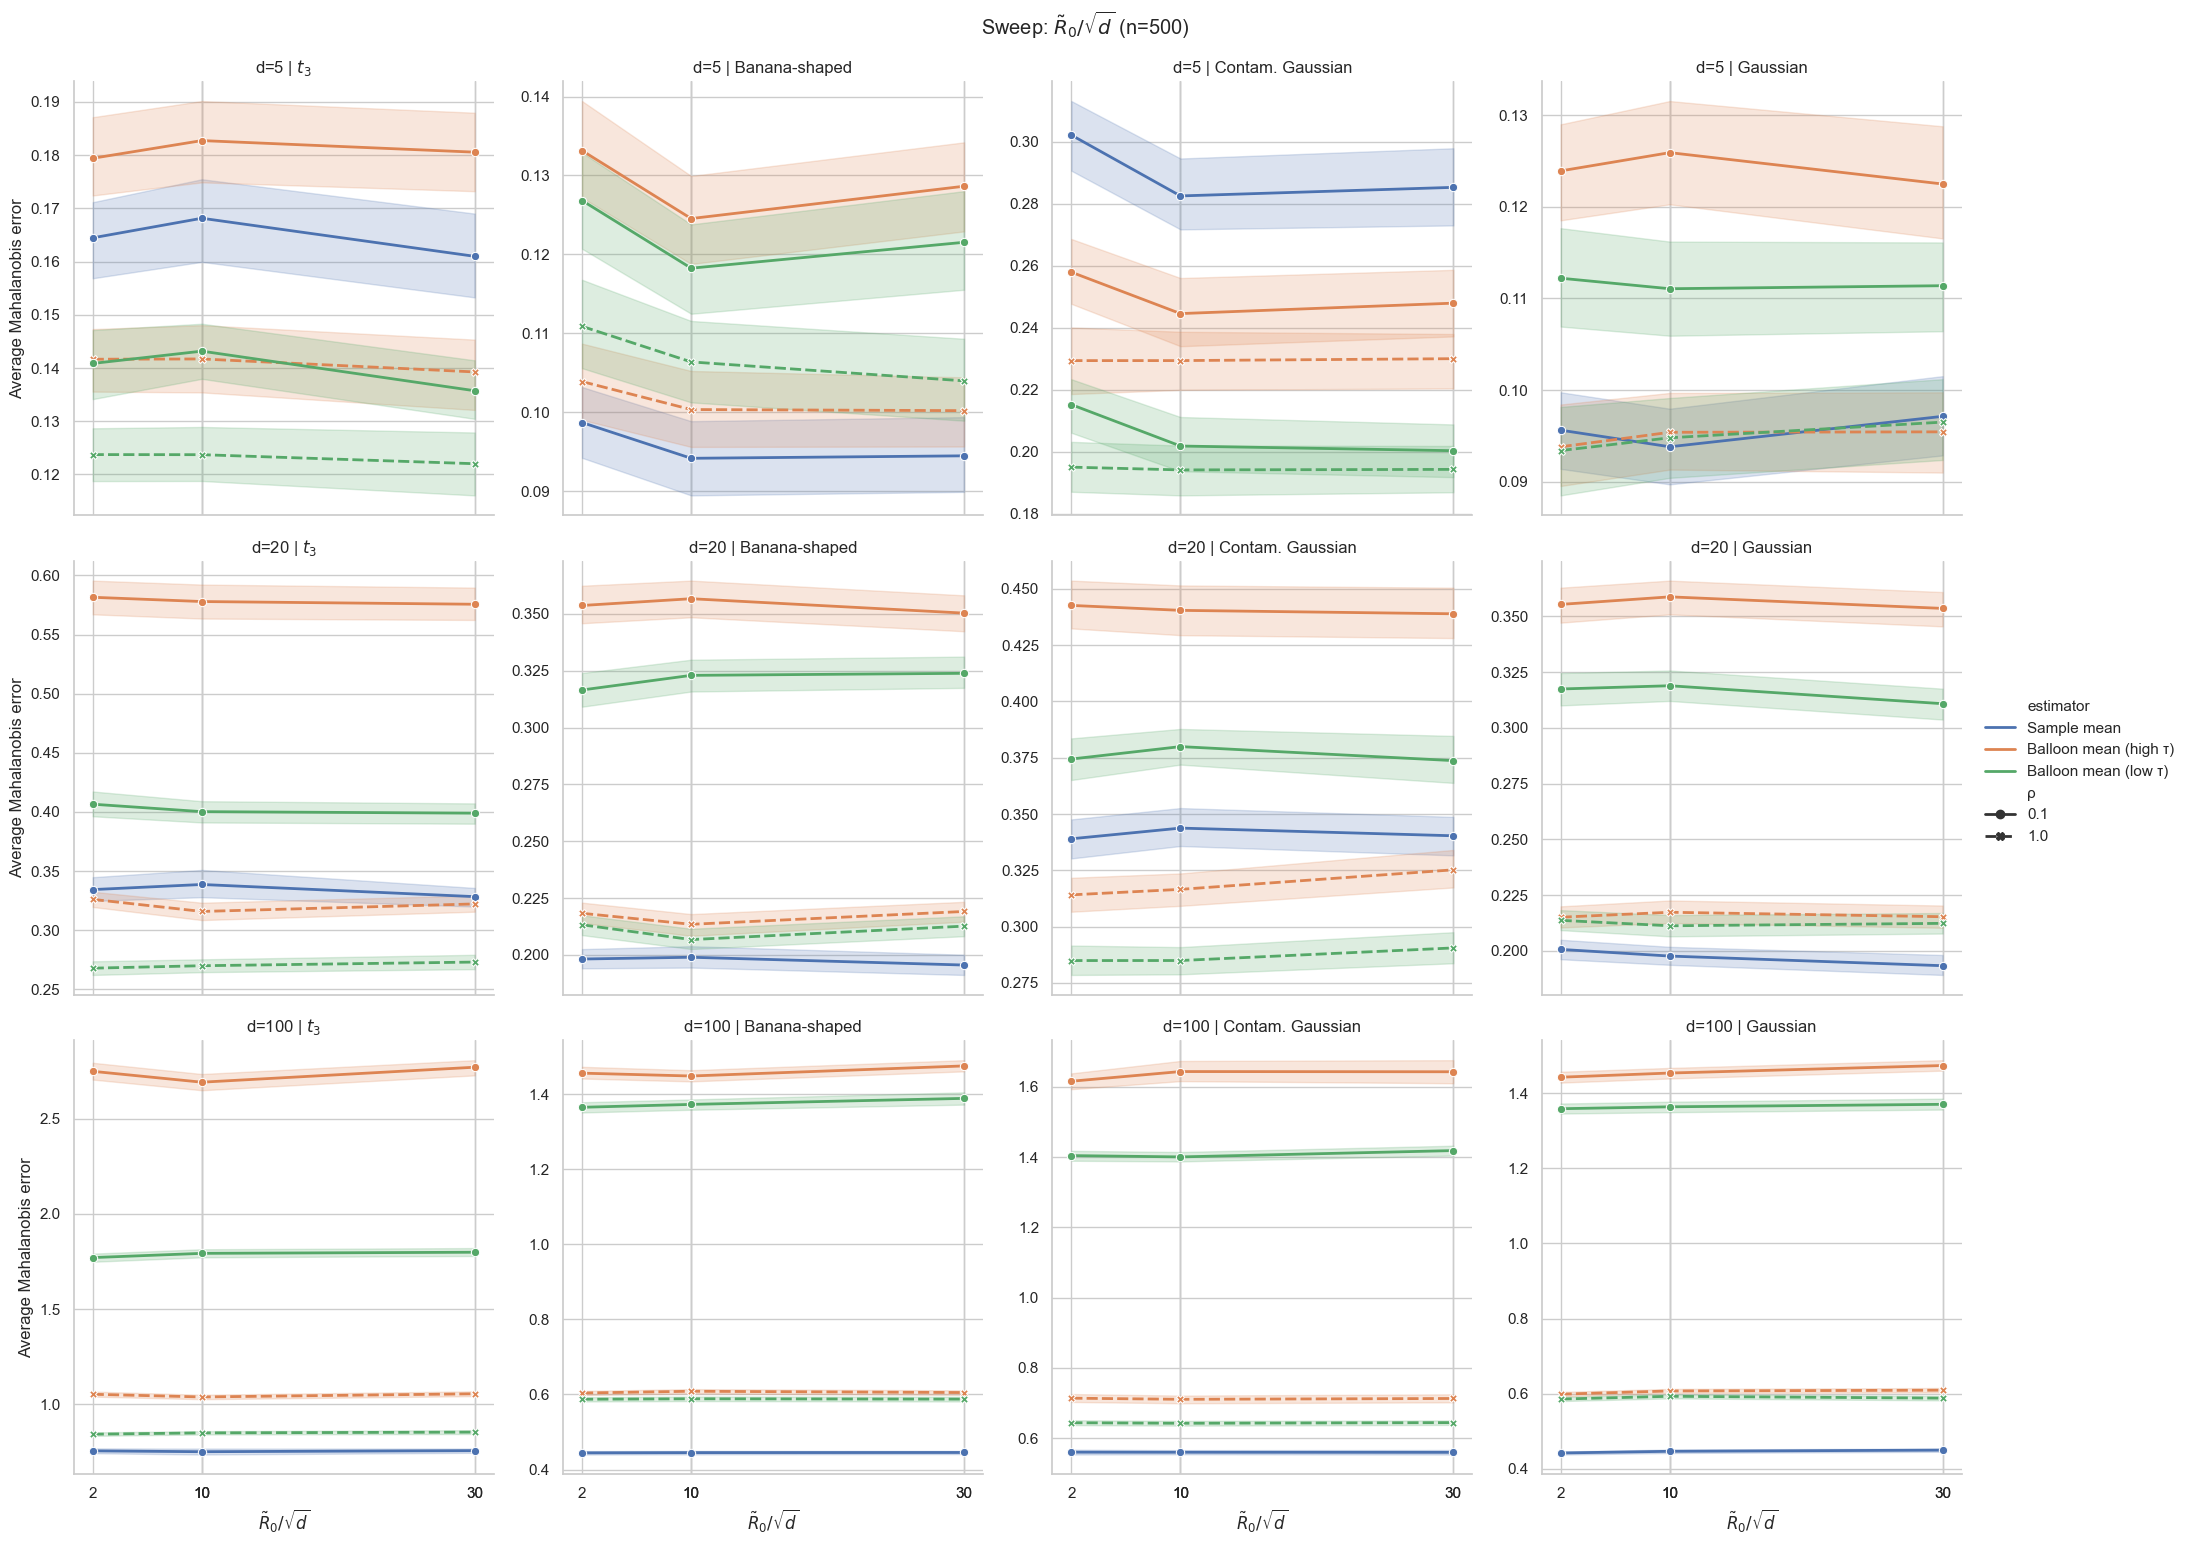

Saved: plots\sweep_R_max_n500.png


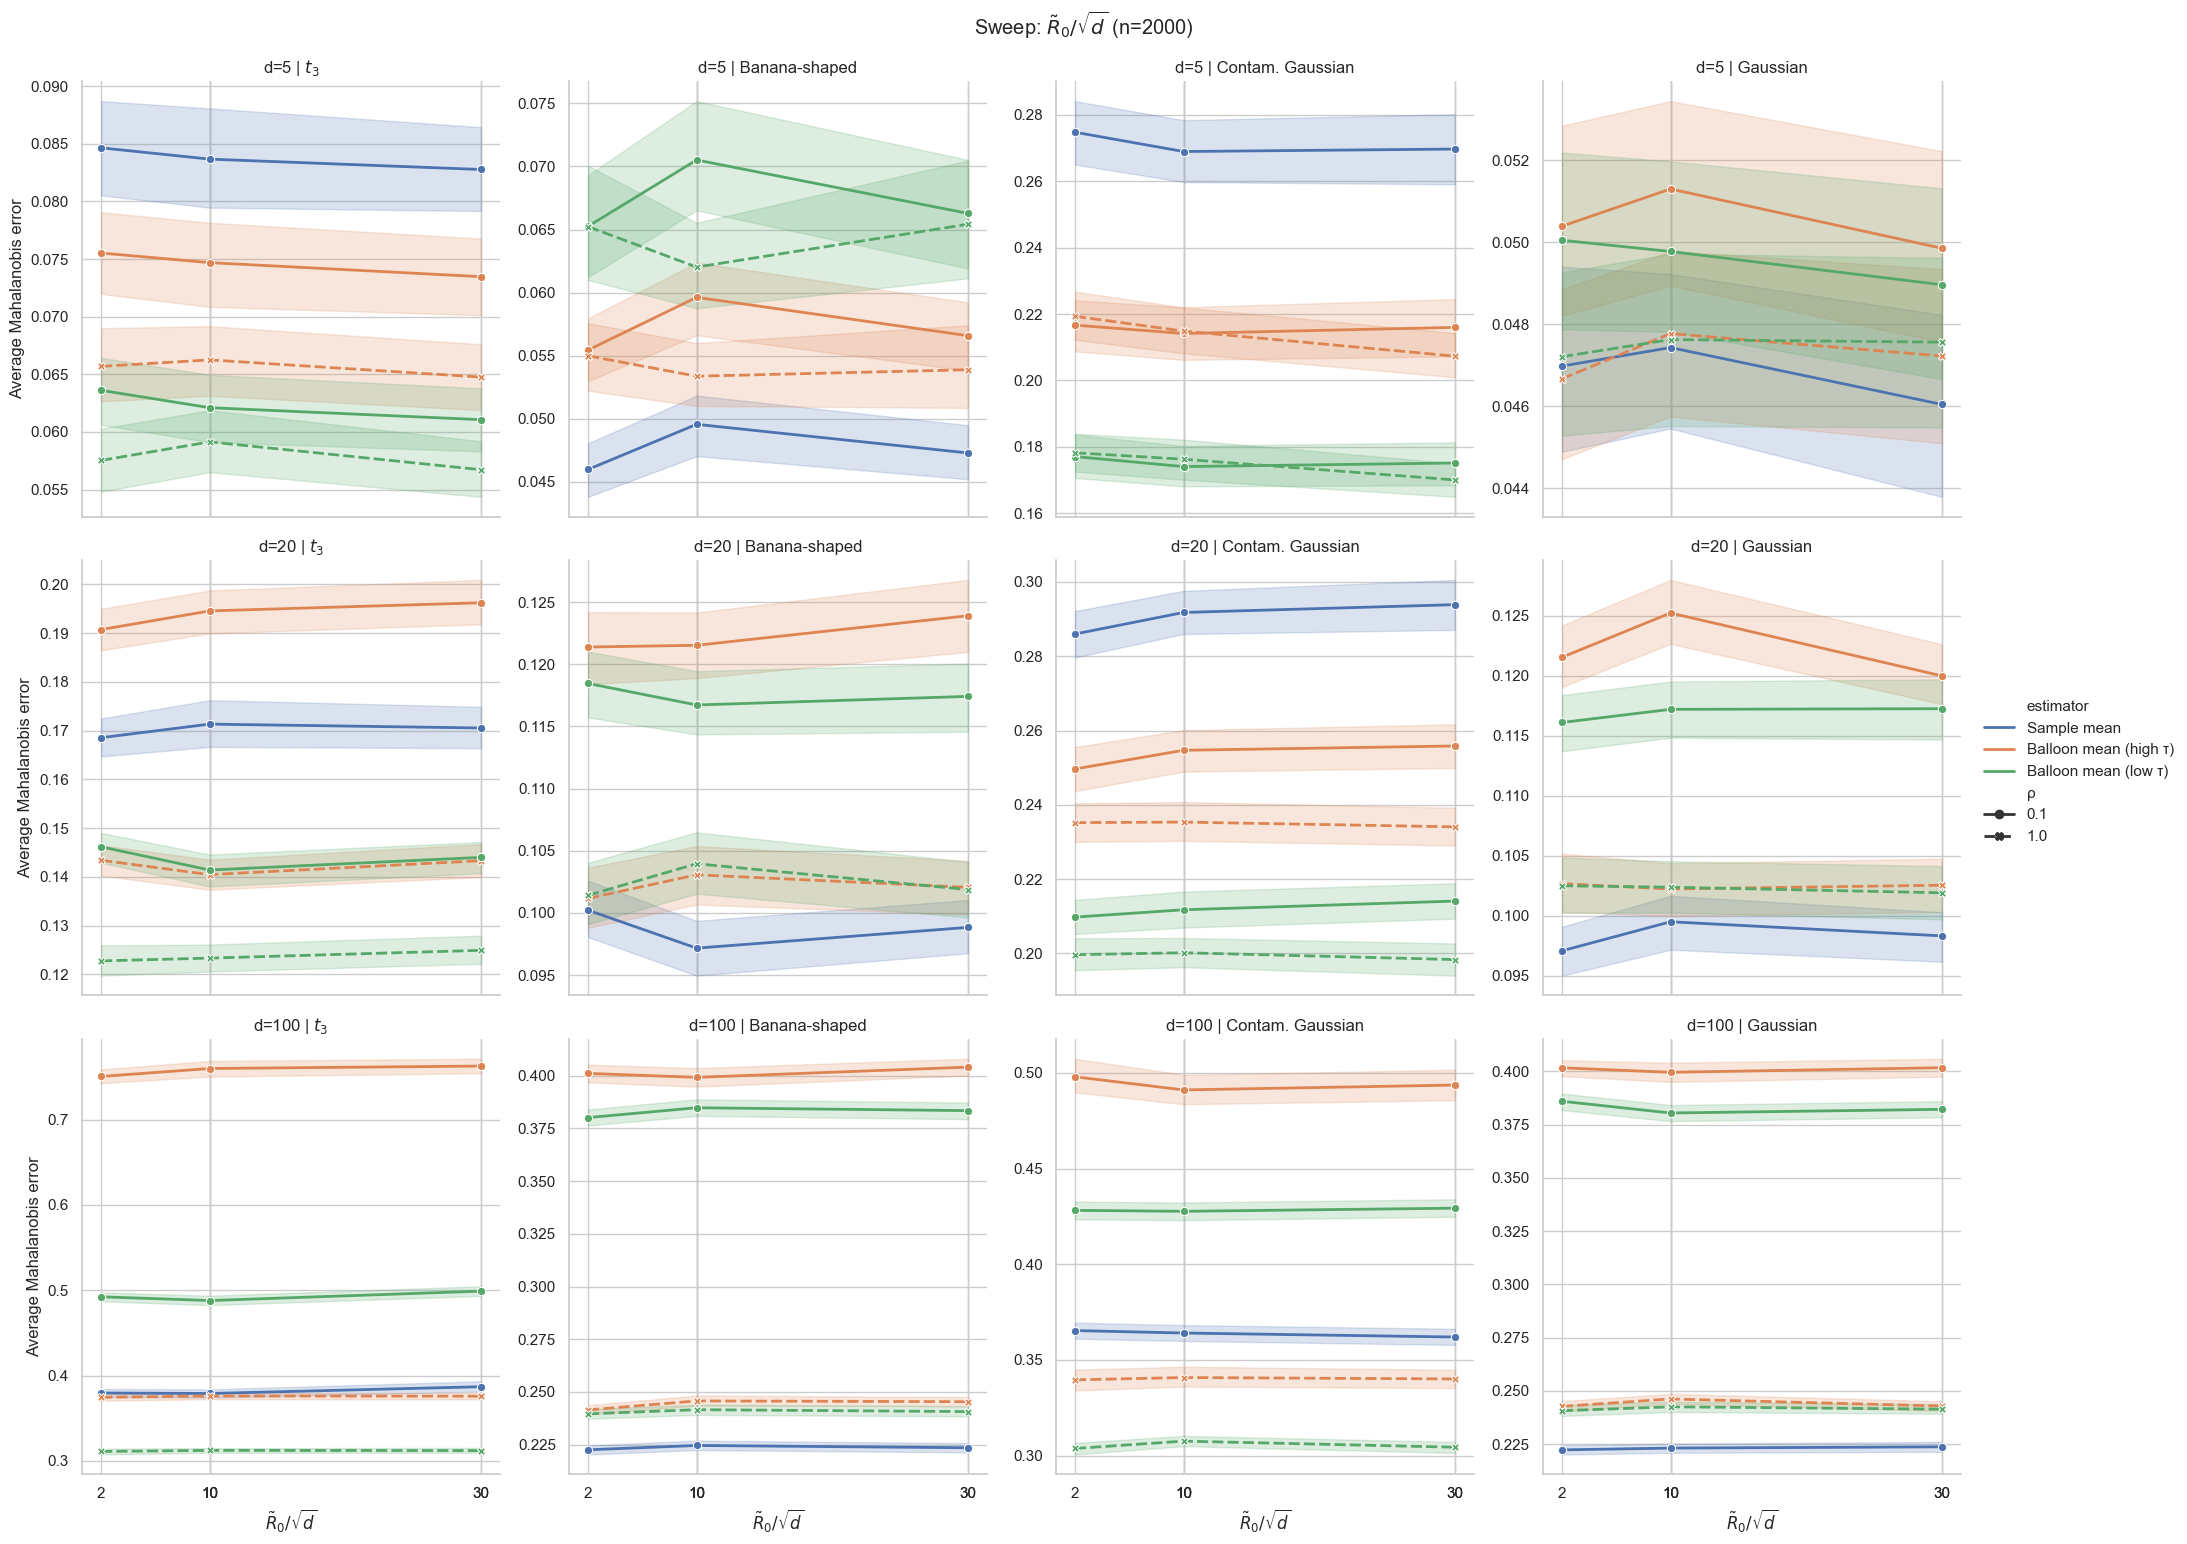

Saved: plots\sweep_R_max_n2000.png


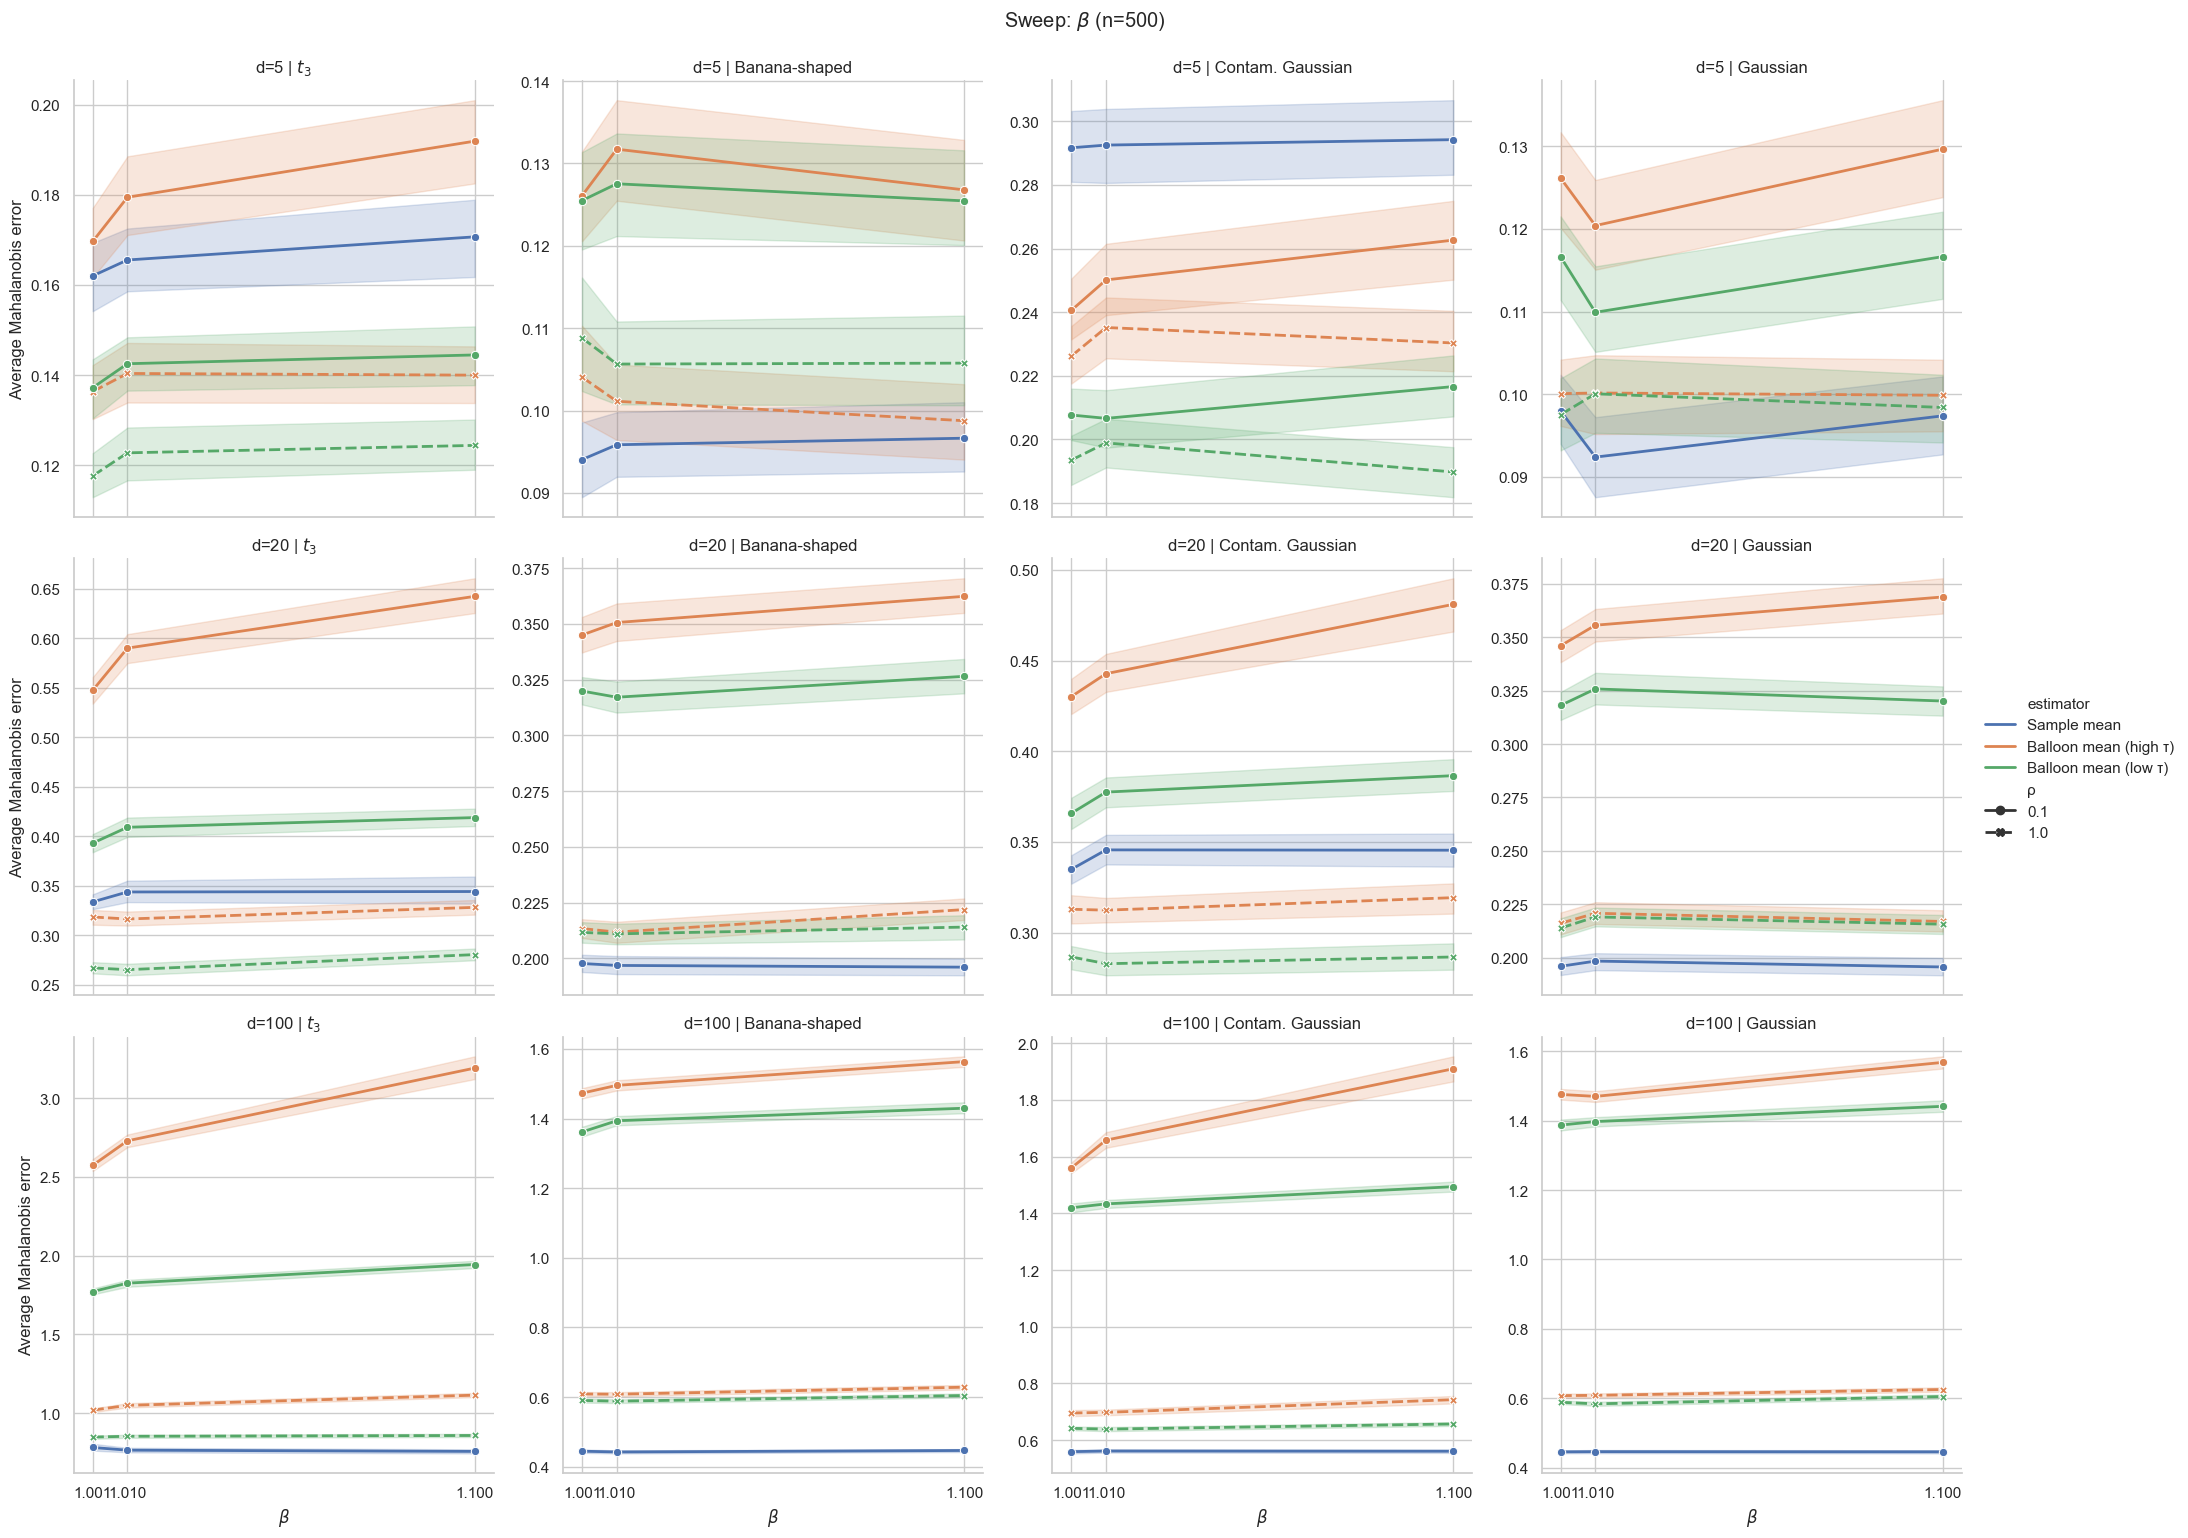

Saved: plots\sweep_beta_n500.png


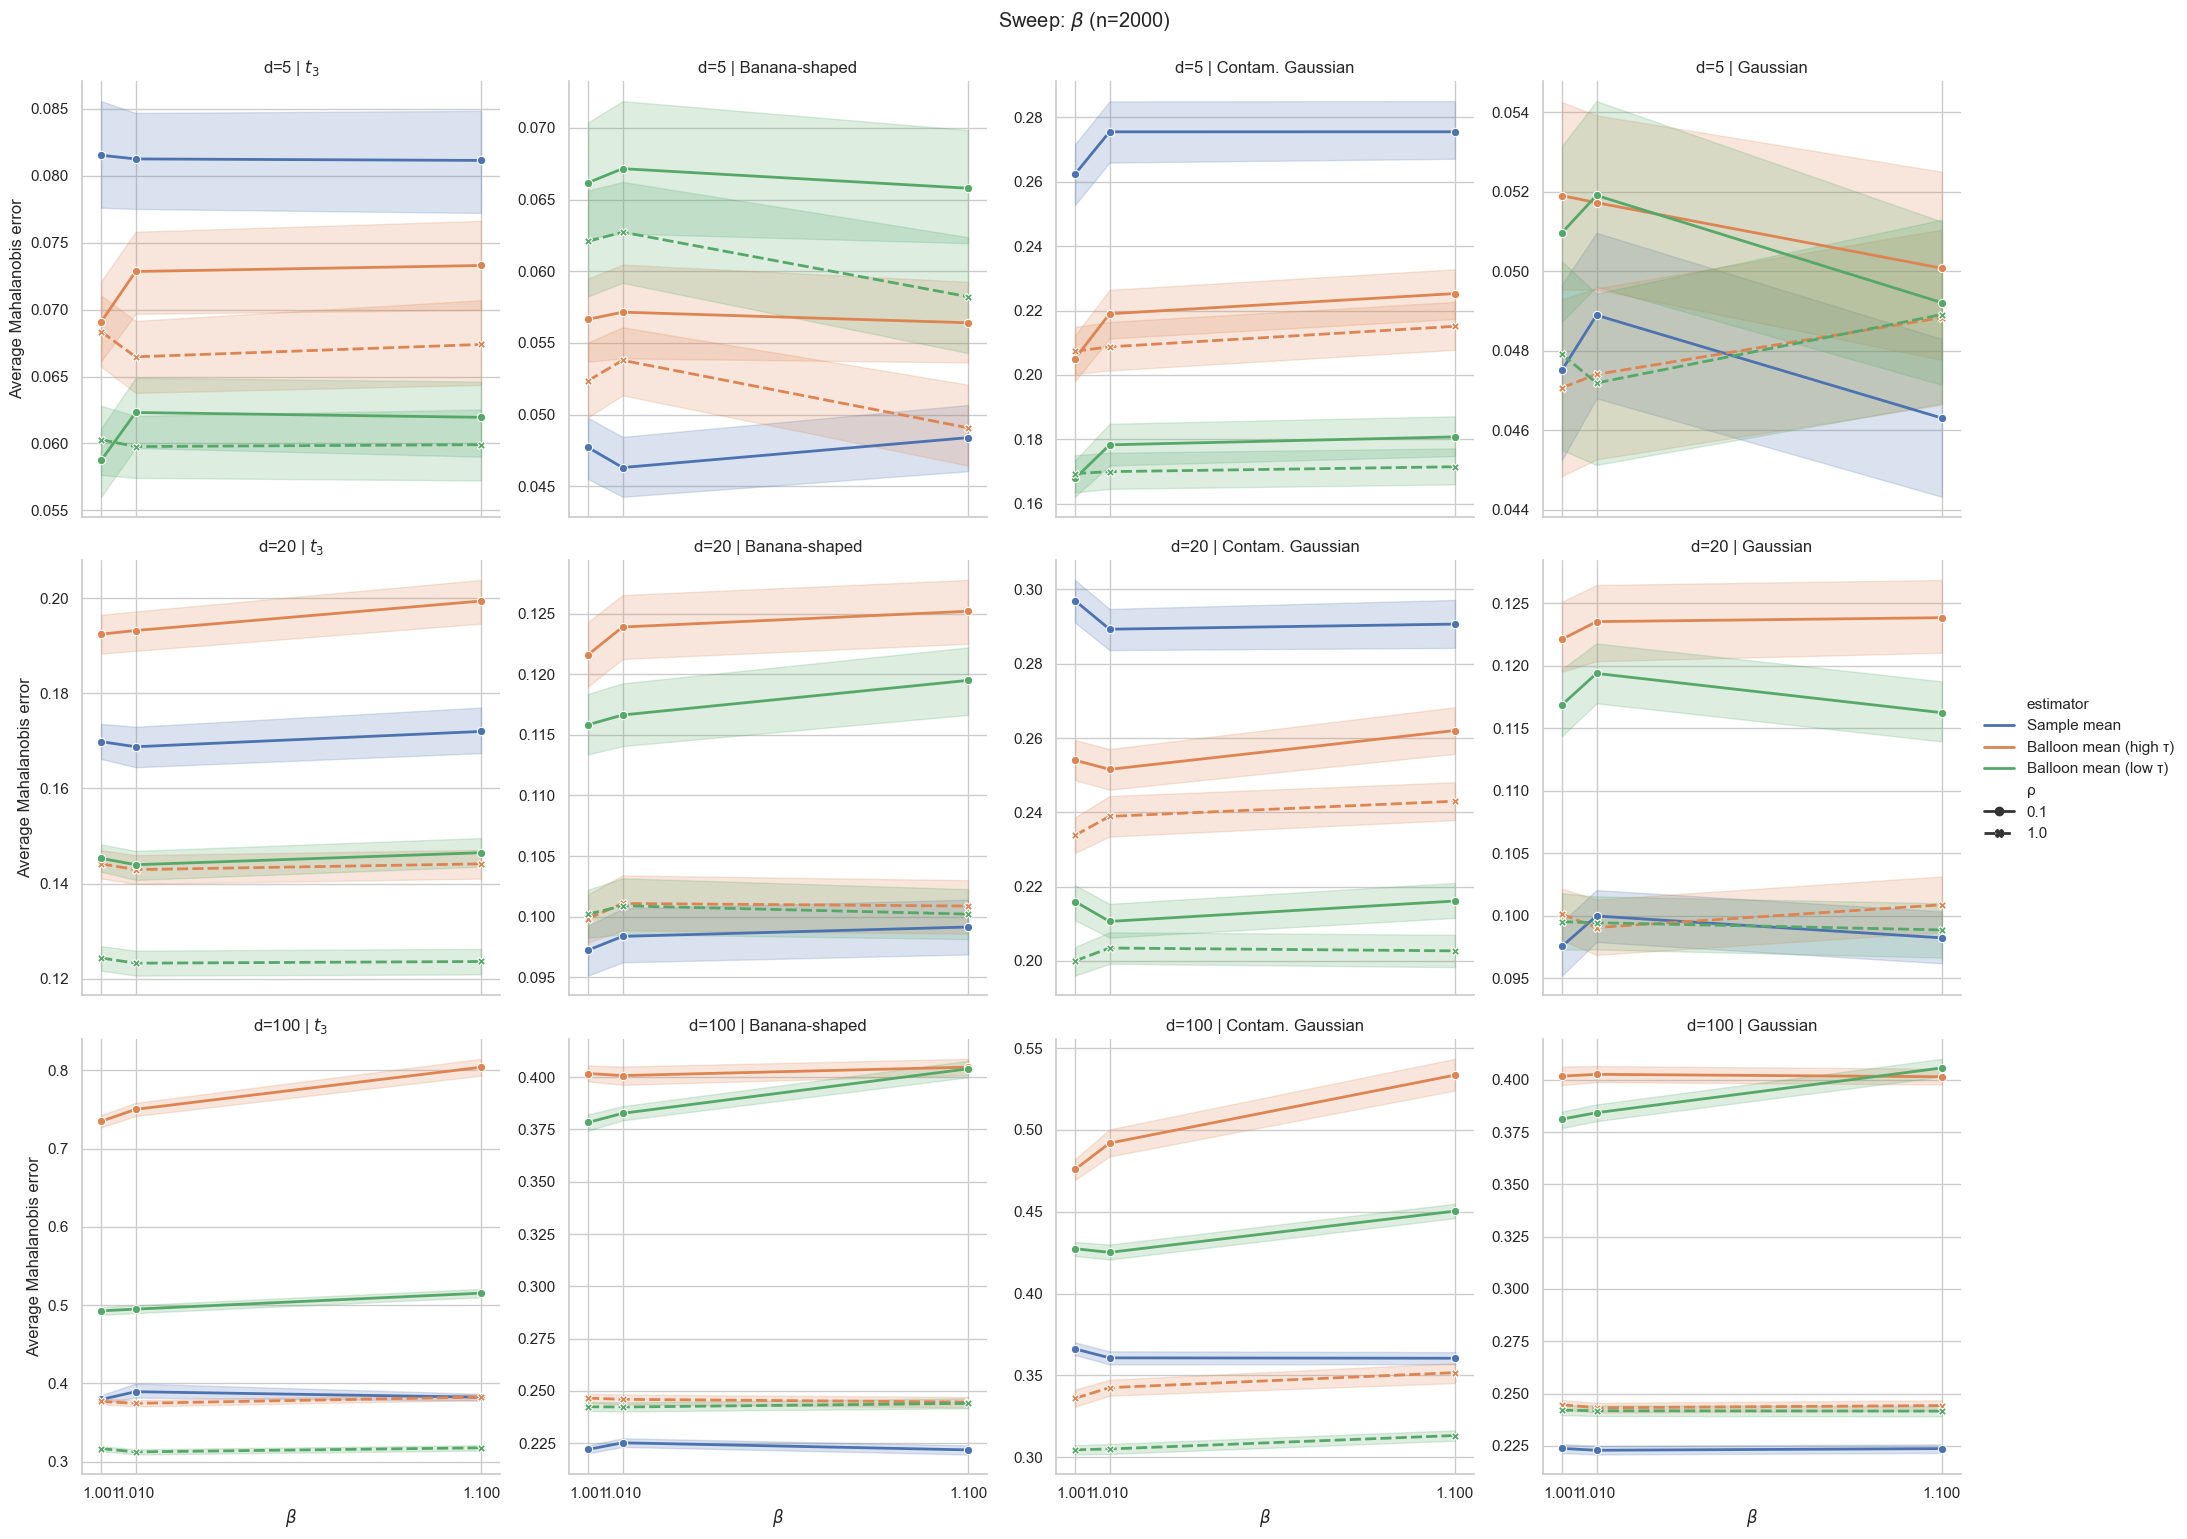

Saved: plots\sweep_beta_n2000.png


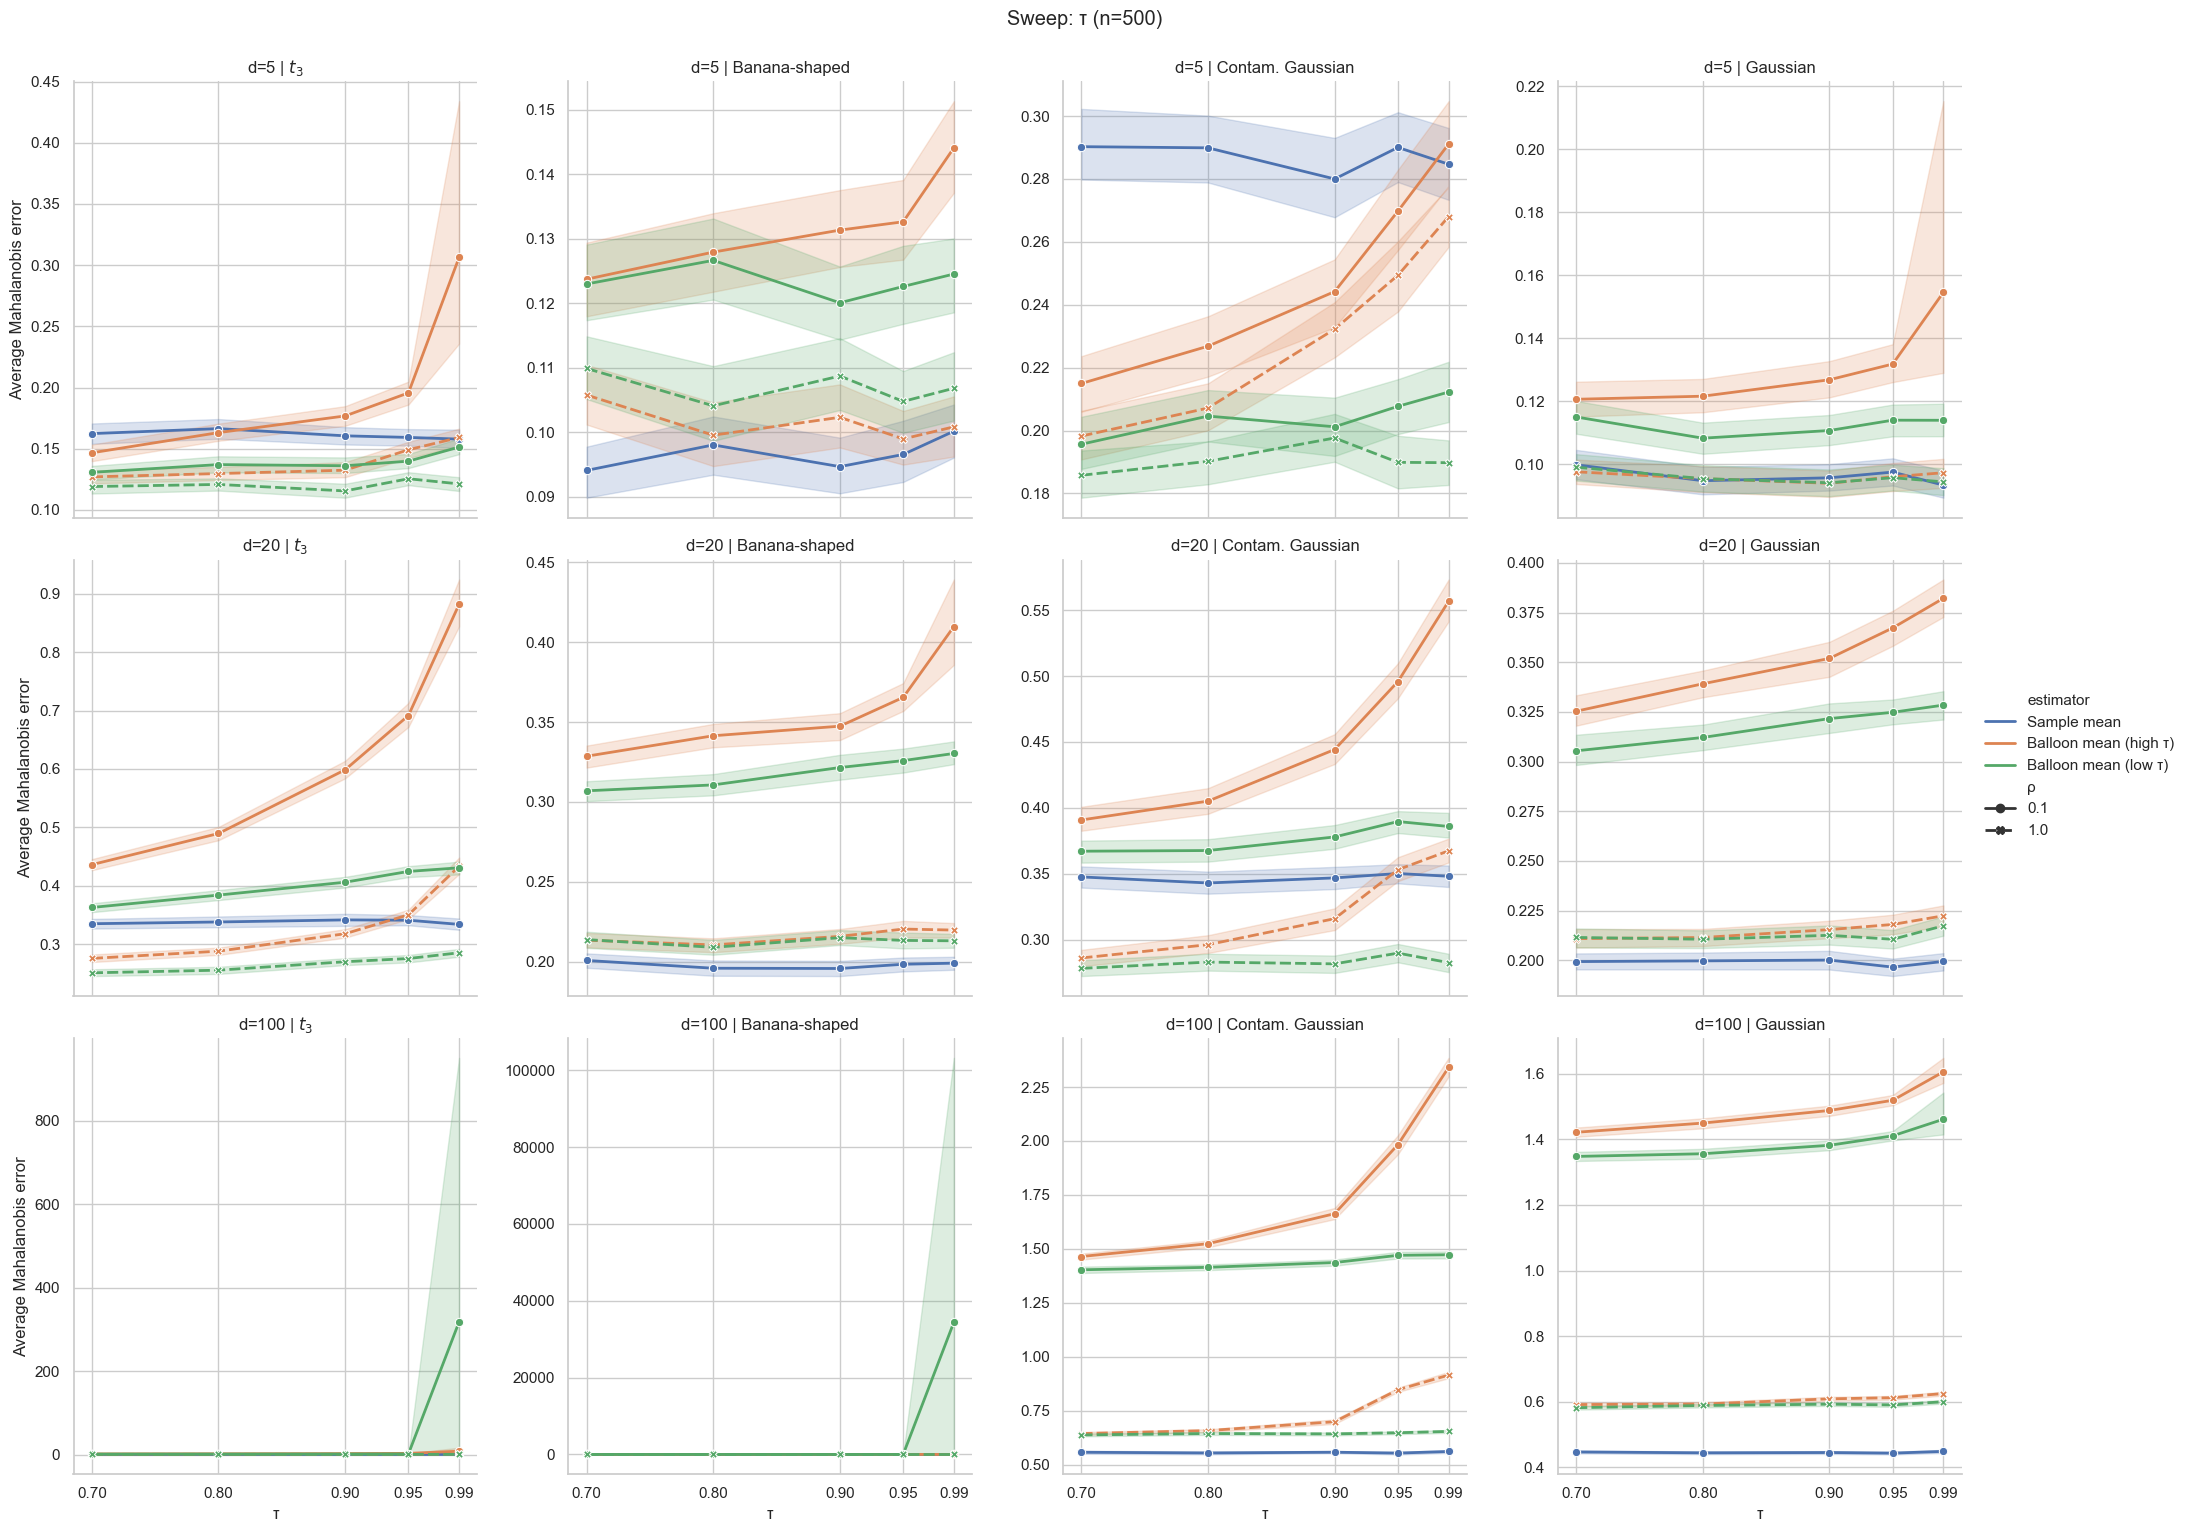

Saved: plots\sweep_tau_n500.png


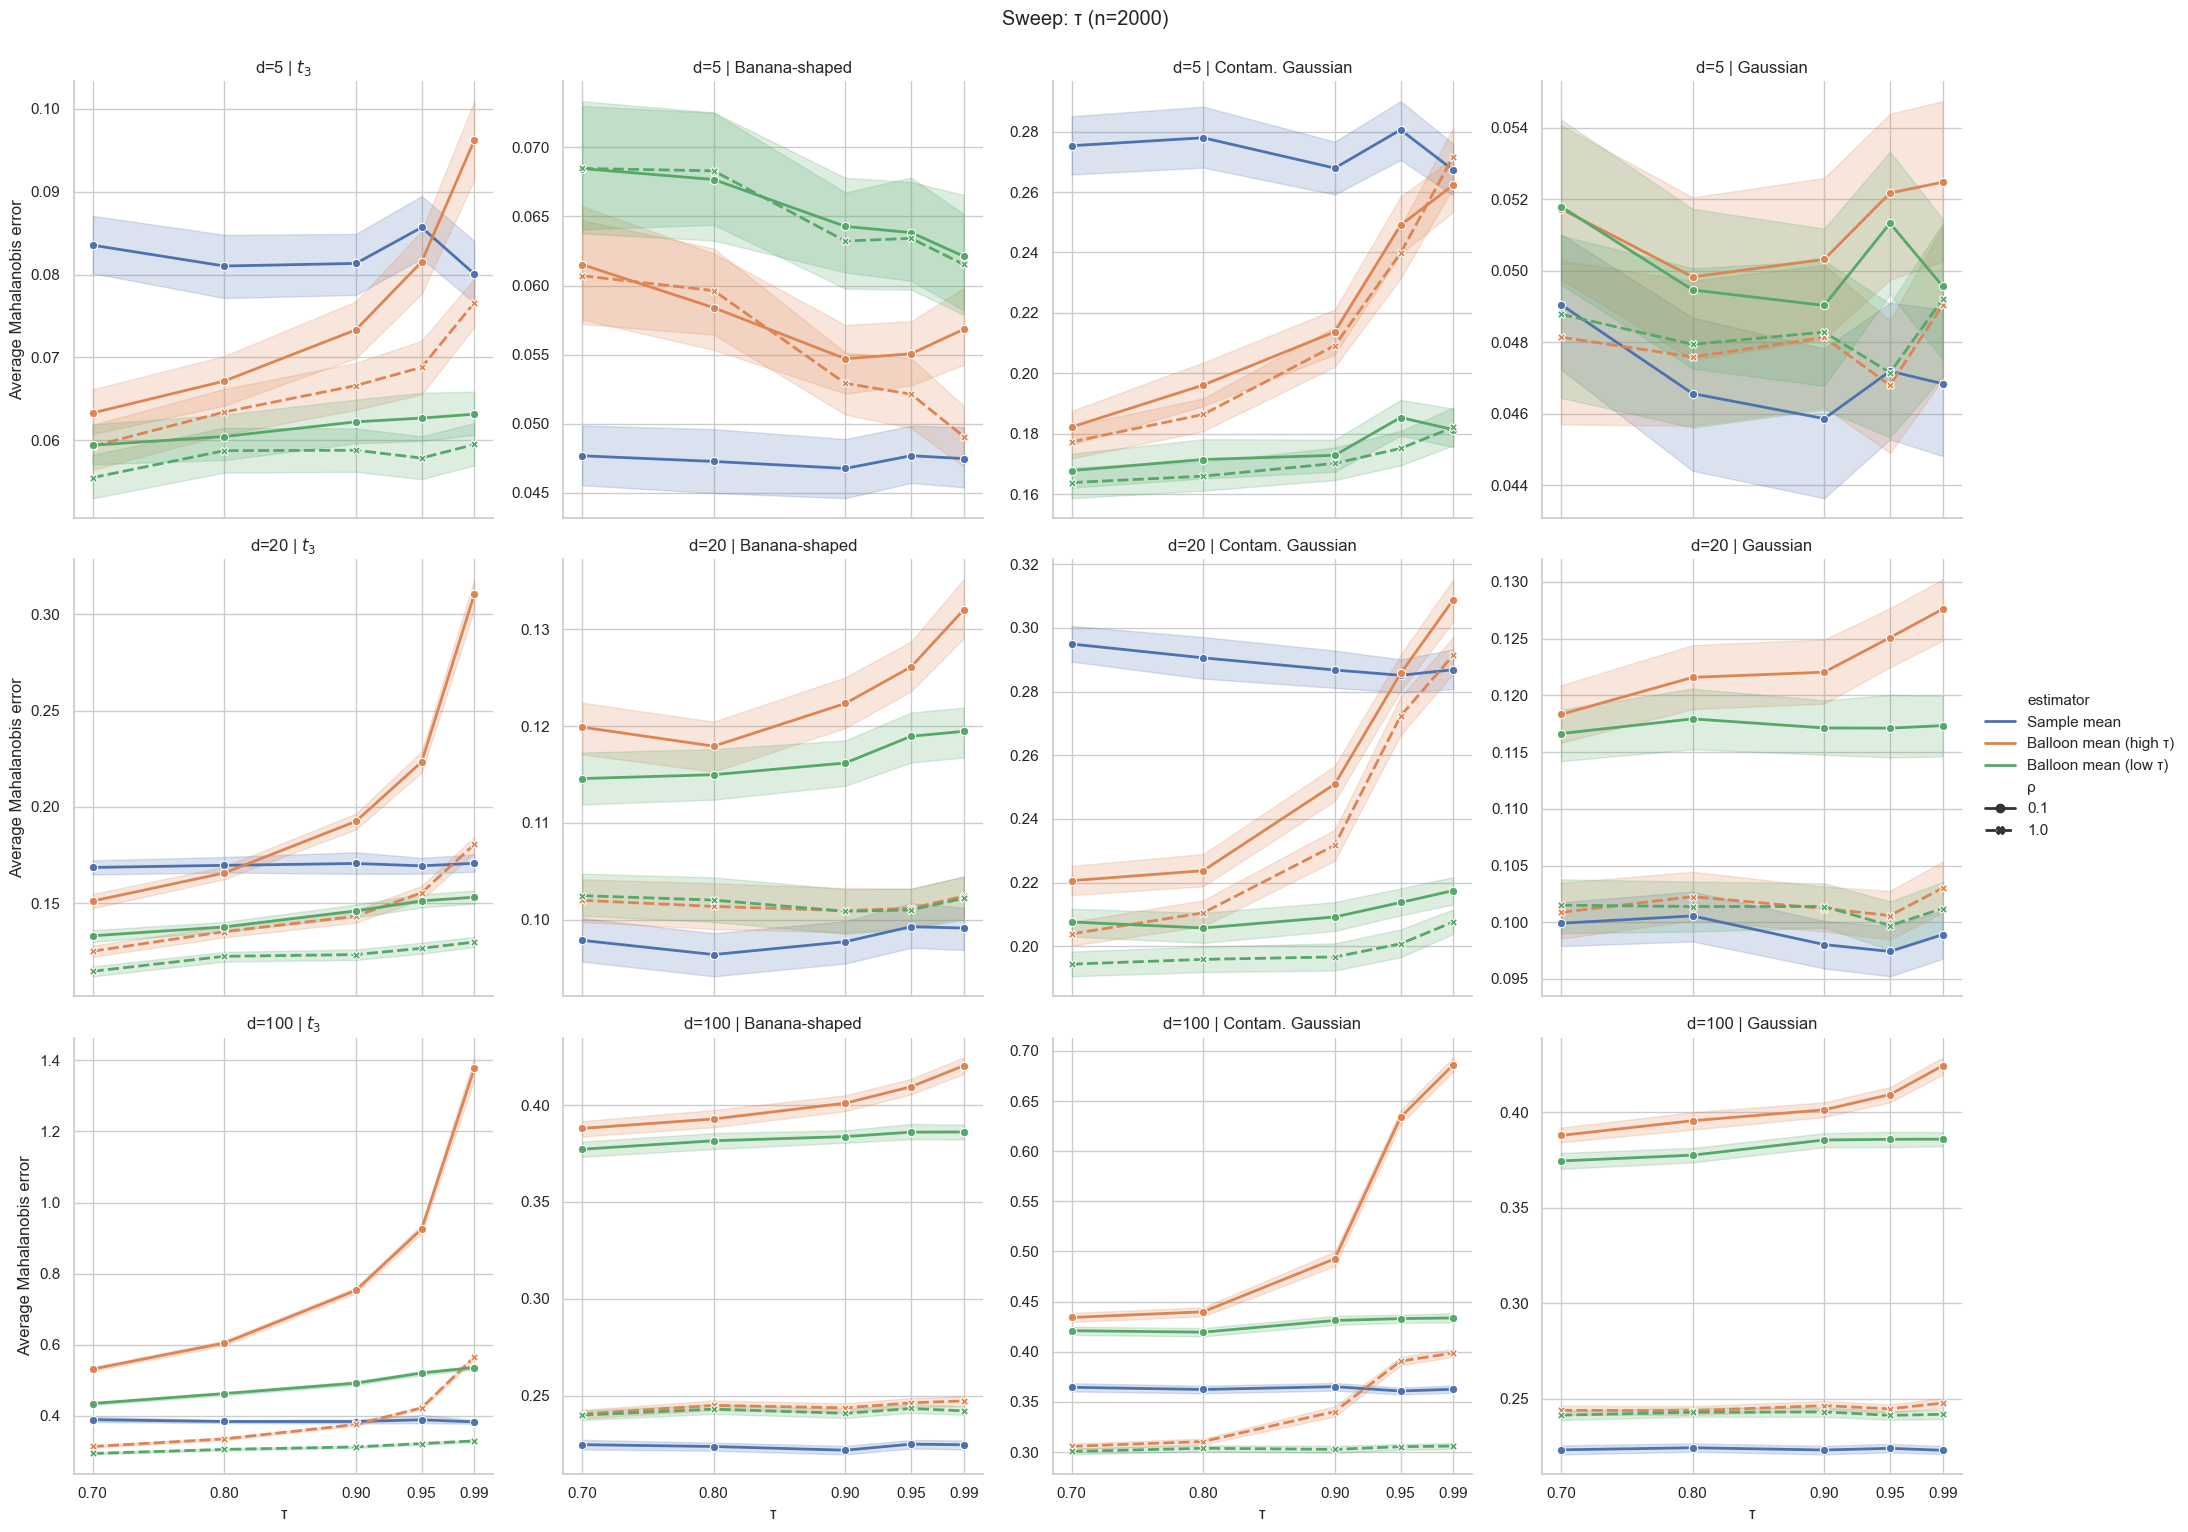

Saved: plots\sweep_tau_n2000.png


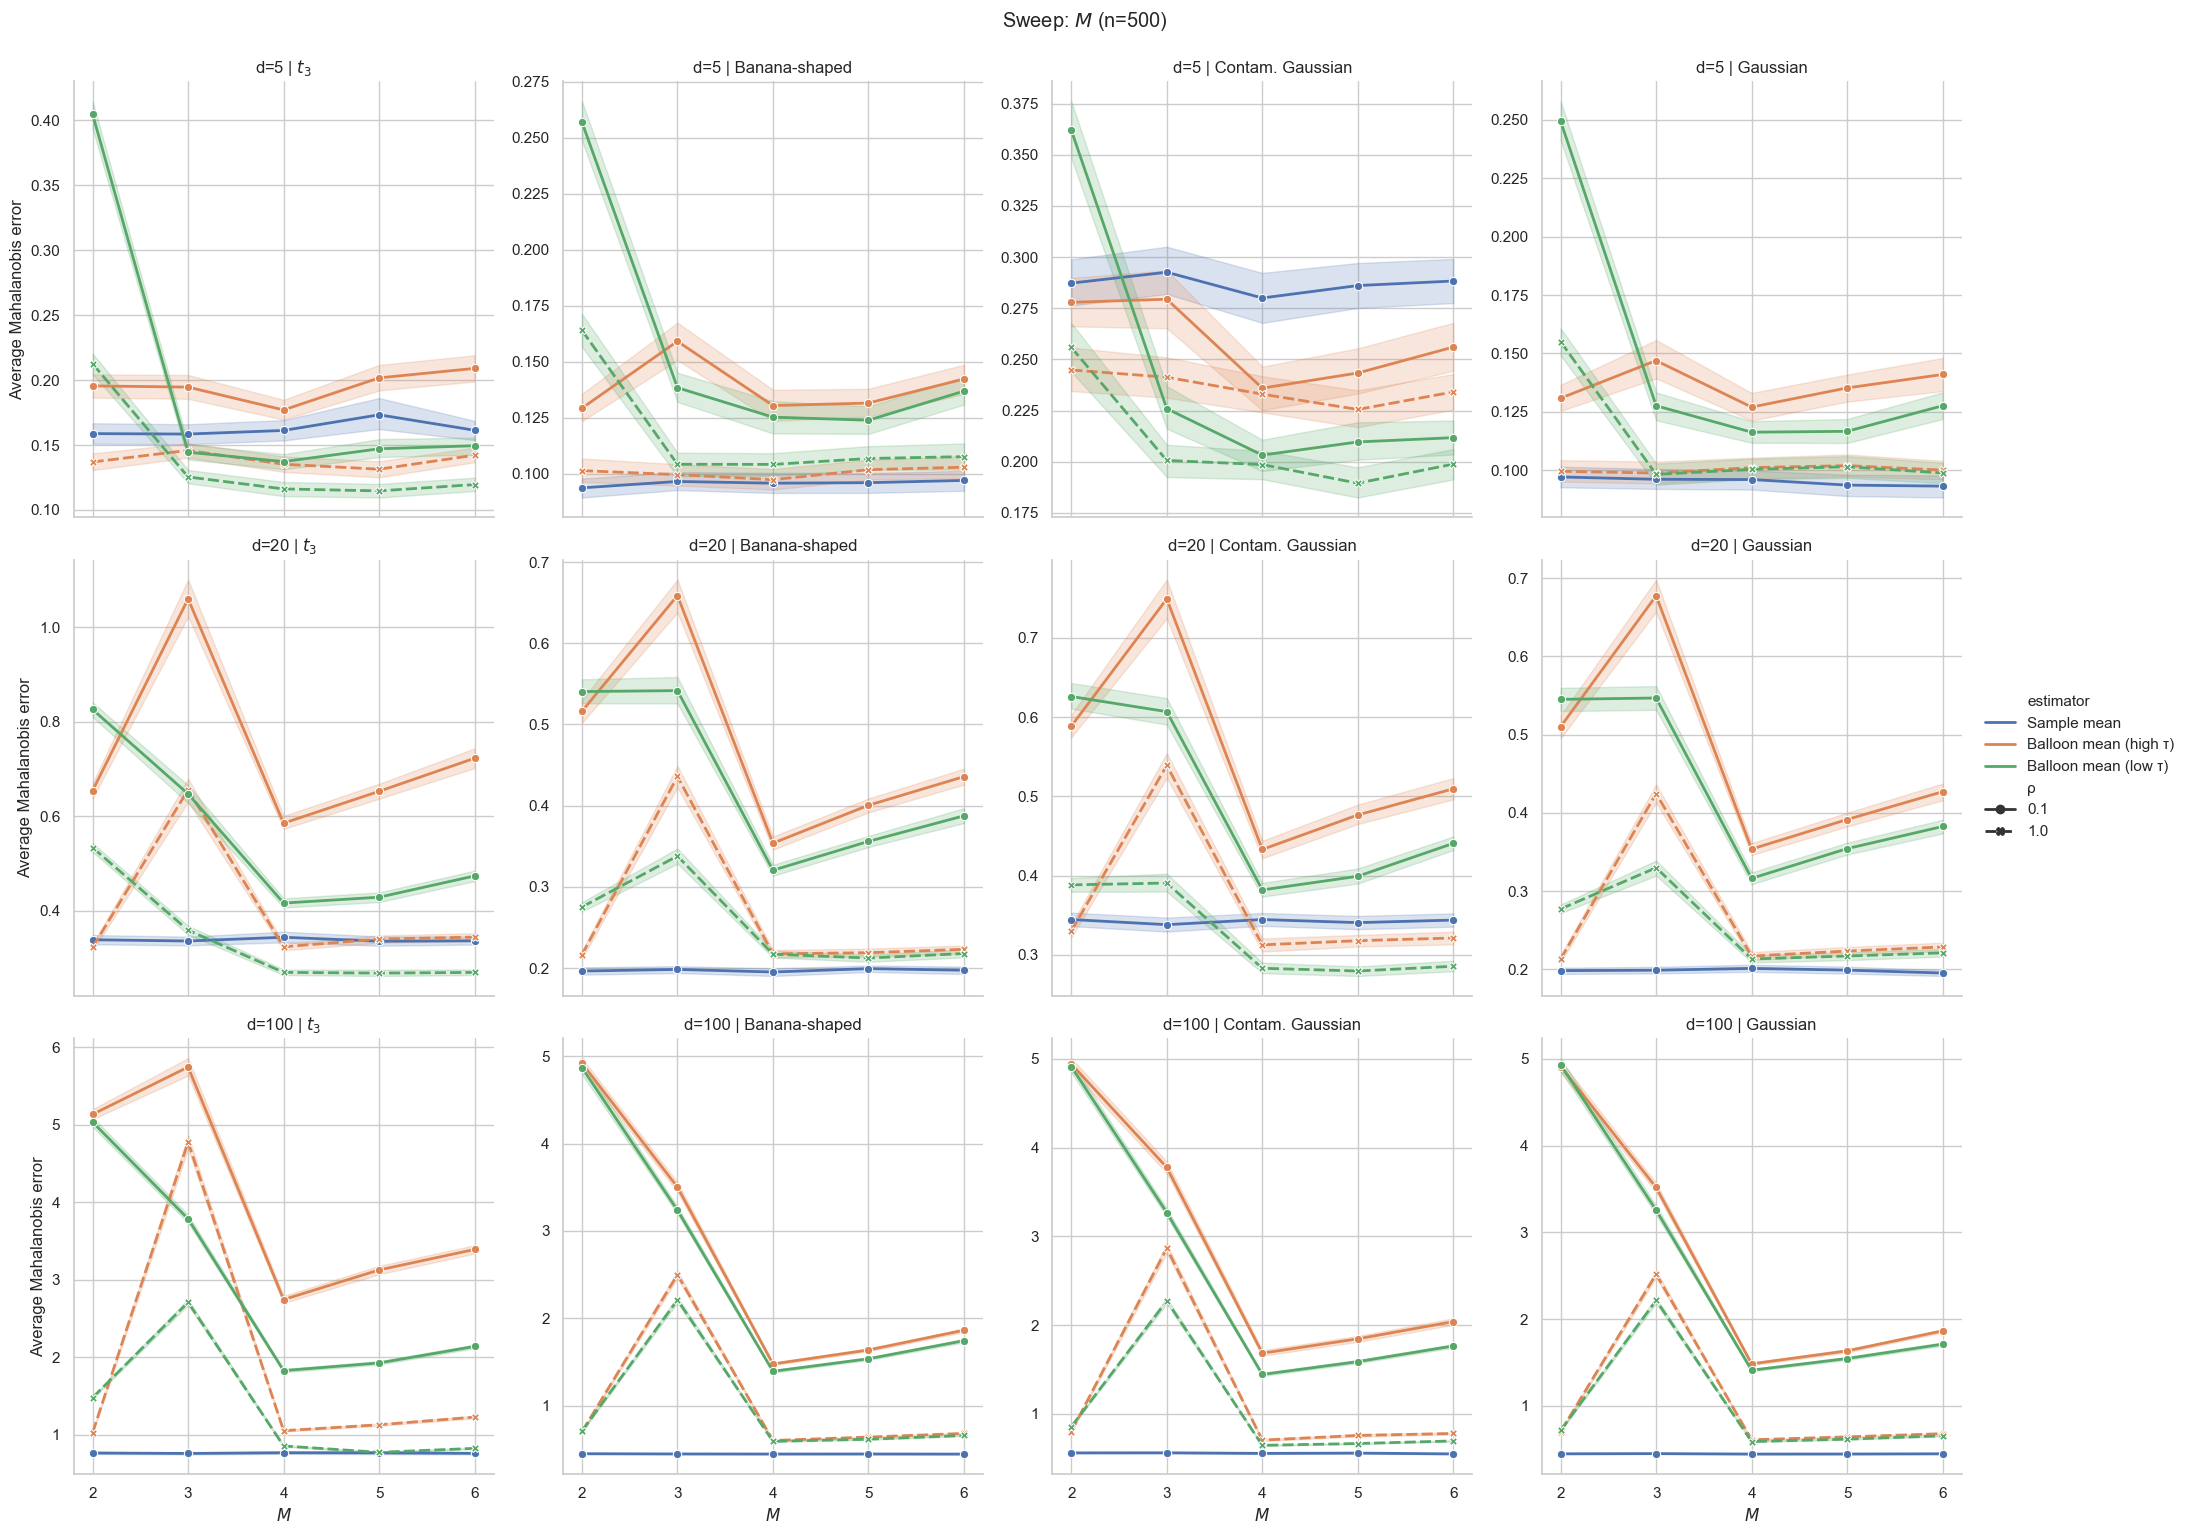

Saved: plots\sweep_iterations_n500.png


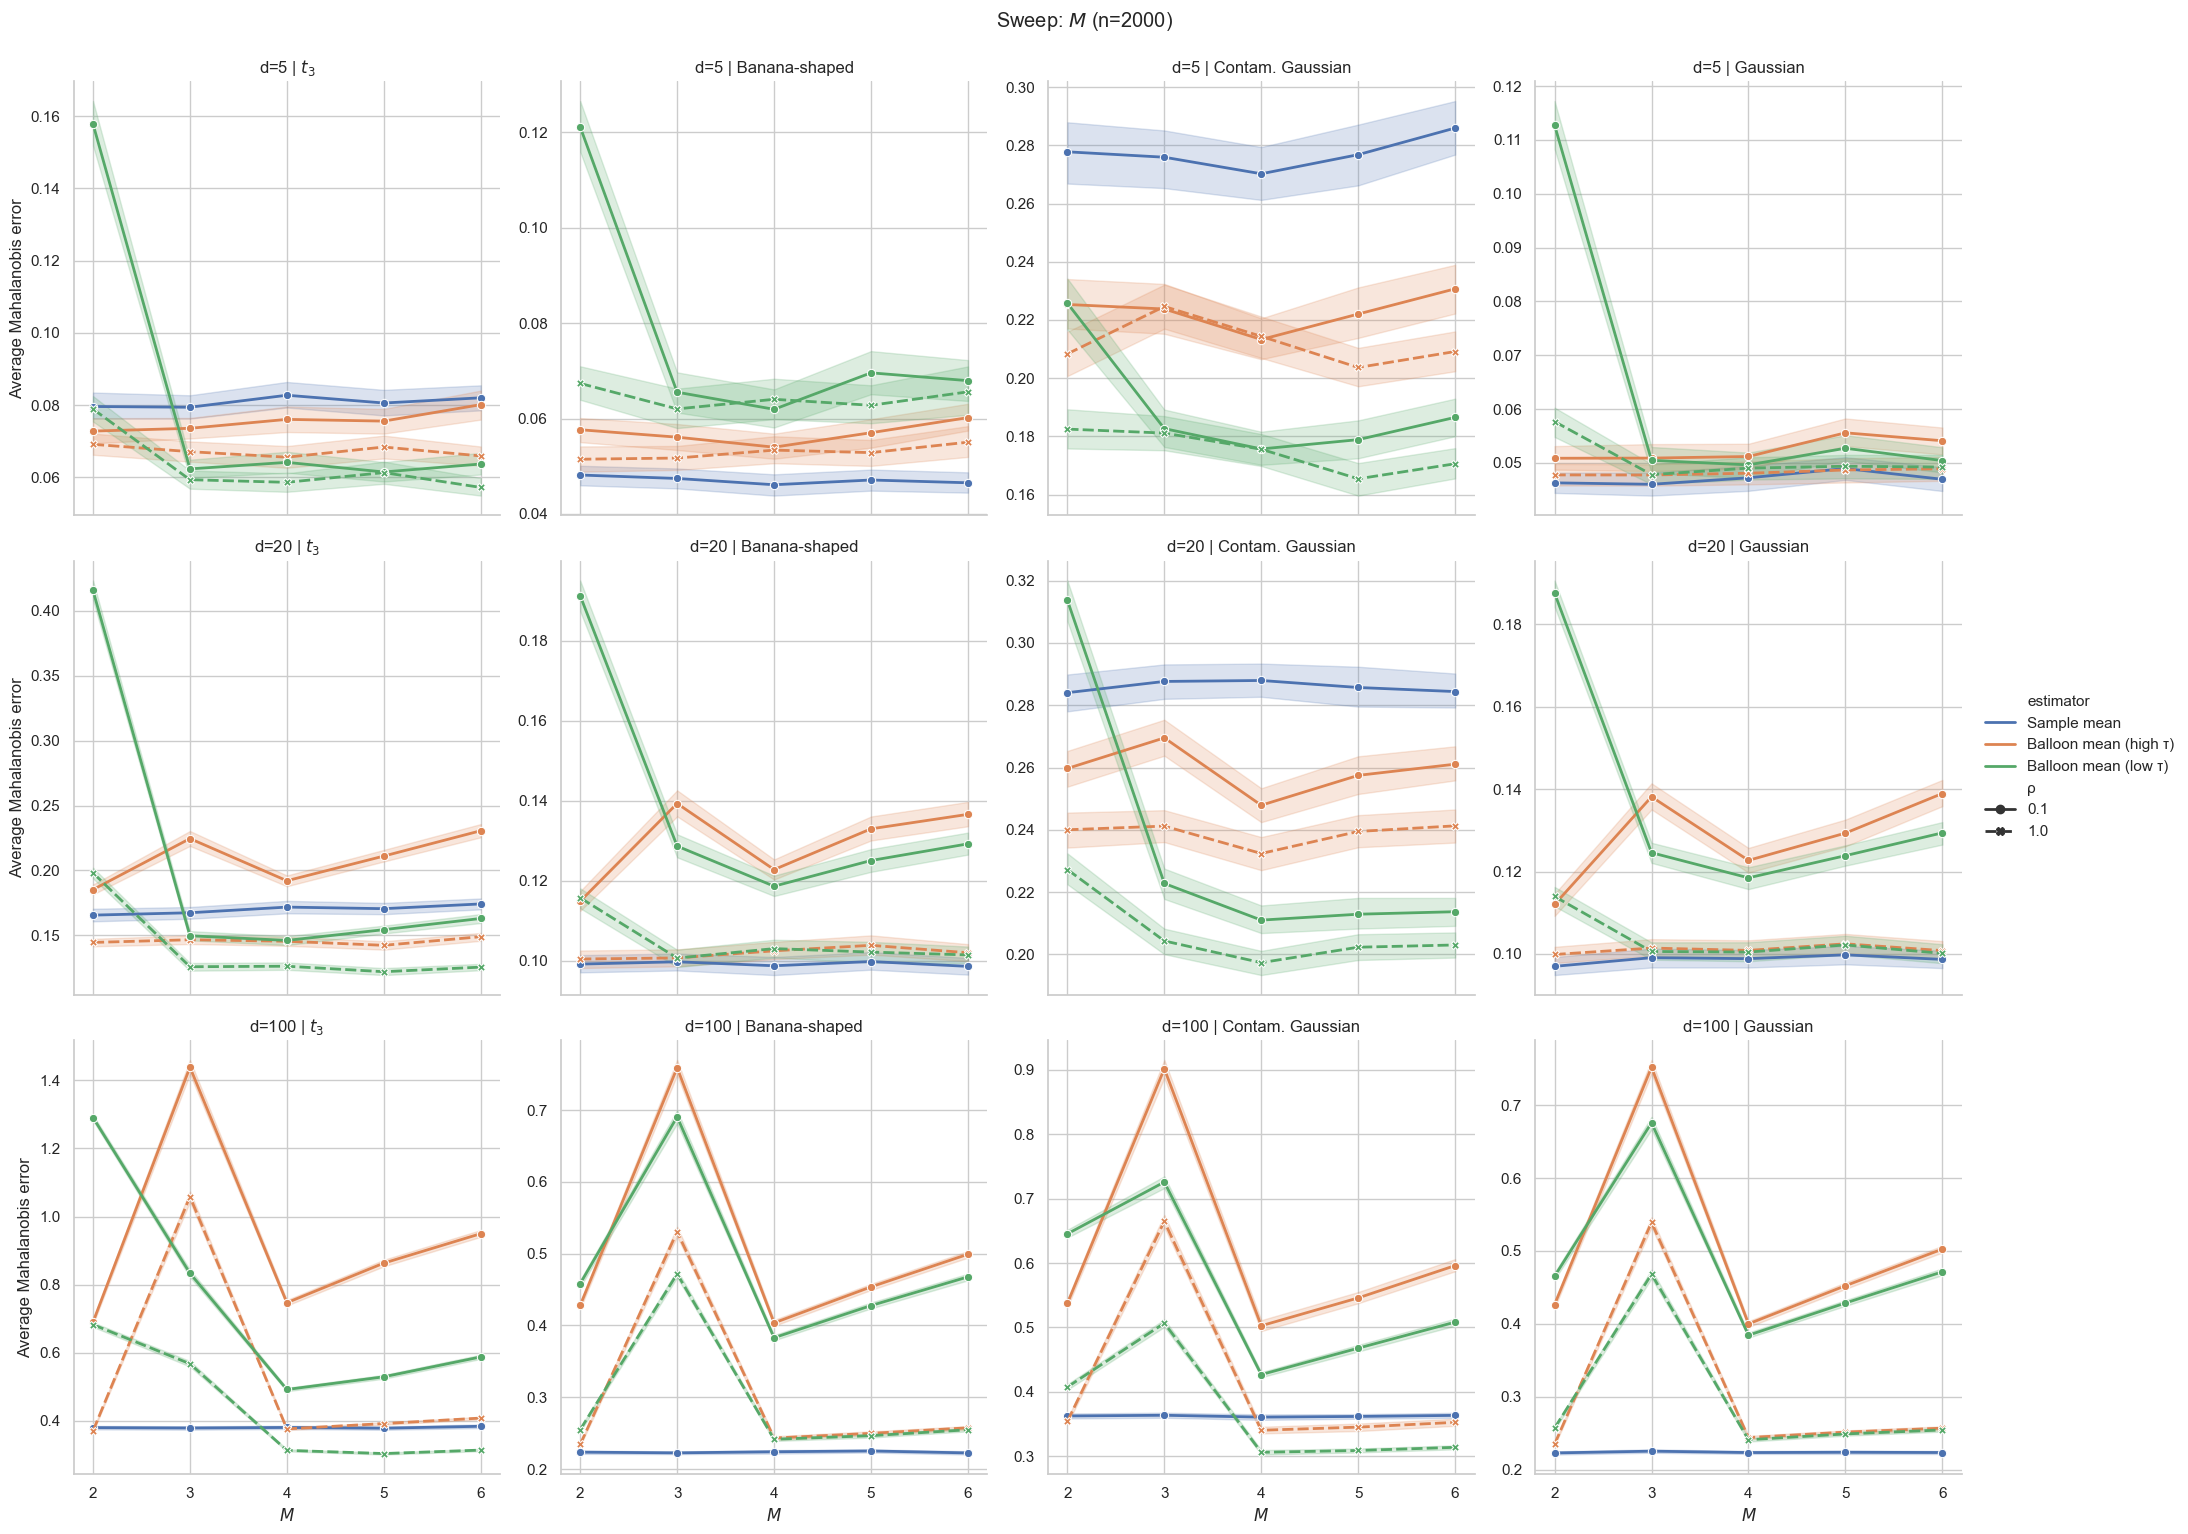

Saved: plots\sweep_iterations_n2000.png


In [85]:
d_grid = [5, 20, 100]
n_grid = [500,  2000]
rho_grid= [0.1,1]
plot_all_sweeps(df_list, out_dir="plots")



In [15]:
df_list[3].tail()

dist     n    d  rep    ρ  Sample mean  Balloon mean (high τ)  \
47995  Banana-shaped  2000  100  195  1.0     0.228914               0.261583   
47996  Banana-shaped  2000  100  196  1.0     0.197086               0.219503   
47997  Banana-shaped  2000  100  197  1.0     0.226885               0.266446   
47998  Banana-shaped  2000  100  198  1.0     0.242594               0.269418   
47999  Banana-shaped  2000  100  199  1.0     0.237720               0.260468   

       Balloon mean (low τ)  $\eta$  $M$  $\beta$    τ  $\tilde R_{0}$  \
47995              0.237828     0.1    5     1.01  0.9           500.0   
47996              0.239143     0.1    5     1.01  0.9           500.0   
47997              0.276719     0.1    5     1.01  0.9           500.0   
47998              0.278939     0.1    5     1.01  0.9           500.0   
47999              0.256236     0.1    5     1.01  0.9           500.0   

       R_max_coef  
47995        50.0  
47996        50.0  
47997        50.0  
47998        50.0  
47999        50.0